# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\aksha\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:35<00:00, 2479.04it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

 37%|███████████████████████████▎                                              | 32464/87773 [00:07<00:13, 4176.40it/s]C:\Users\aksha\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▋                      | 61327/87773 [00:14<00:06, 4048.74it/s]C:\Users\aksha\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 74%|███████████████████████████████████████████████████████                   | 65304/87773 [00:15<00:06, 3292.89it/s]C:\Users\aksha\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8617069125175476), ('good', 0.8264305591583252), ('awesome', 0.8236678838729858), ('excellent', 0.8193342685699463), ('terrific', 0.7835198044776917), ('wonderful', 0.7825714349746704), ('amazing', 0.7535933256149292), ('perfect', 0.7441102266311646), ('nice', 0.7299010753631592), ('fabulous', 0.7013991475105286)]
[('greatest', 0.7769392728805542), ('tastiest', 0.7318109273910522), ('best', 0.7244680523872375), ('nastiest', 0.7036882638931274), ('disgusting', 0.6786838173866272), ('cry', 0.6395573019981384), ('terrible', 0.6376215219497681), ('horrible', 0.6296714544296265), ('hottest', 0.5905436873435974), ('softest', 0.590268075466156)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [03:51<00:00, 379.66it/s]


87773
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [34]:
# Initializing tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_data  = tfidf_vectorizer.fit_transform(preprocessed_reviews)

In [35]:
top_wrds = tfidf_vectorizer.get_feature_names()

In [36]:
print(top_wrds[0:10])
#print([idf_value[i] for i in feat_index[-10:]])

['aa', 'aafco', 'abandoned', 'abdominal', 'ability', 'able', 'abroad', 'absence', 'absent', 'absolute']


### [5.2] Calulation of Co-occurrence matrix

In [37]:
# Will define an array of size 2000x2000 to store co-occurance matrix as we have top 2000 words.
co_mat = np.zeros((10000,10000))
print(co_mat.shape)

(10000, 10000)


In [38]:
# We will create a dictionary that will contain all the words.
# Below we will explain how we are going to update the co-occurance matrix and how we are going to use dictionary.
# We will store words in the dictionary . Word will be the key and its index will be its value.
# Since we have 2000 words we have 2000 rows and columns in the co-occurance matrix. 
# co_mat[i][j] corresponds to the number of times a word top_wrds[j] is present in the window w of top_wrds[i] in the document.
# top_wrds contains top 2000 words.
# The value stored in dictionary corresponding to each word will be used to get column and row number so that we can update Co-occurance matrix.

# Below we will explain how the updatio will be done
# for sentence in reviews:
#    for wrd in sent.splits()
#       row = dict.get(wrd,-1) # if wrd is present then return the index/row number else return -1
#       now we will check for words in window and will update the cell accordingly for that word.
"""
The most important thing you should care about is that while you are scanning through sentence and updating matrix 
for each word . Then sum (index of current word + window size ) < len(review.splits()). Otherwise list index out of range
will be thrown by python.
"""
 

'\nThe most important thing you should care about is that while you are scanning through sentence and updating matrix \nfor each word . Then sum (index of current word + window size ) < len(review.splits()). Otherwise list index out of range\nwill be thrown by python.\n'

In [39]:
# Actual implementation.
# Creating a dictionary
vocab = {}
for i in range(len(top_wrds)):
    vocab[top_wrds[i]] = i # Word will be key and index will be value. 

# Updating the co-occurance matrix.
# We are taking window size of 3 in both forward and backword direction.
for sent in tqdm(preprocessed_reviews):
    wrds = sent.split()
    for i in range(len(wrds)):
        row = vocab.get(wrds[i],-1)  # Returns row number for the word else return -1.
        # Checking if this is the first word of the sentence as we cant check backwords in the window.
        if(i == 0 and i+3<len(wrds)):
            
            col1 = vocab.get(wrds[i+1],-1) # Getting col for 1st wrd in forward direction in window.
            col2 = vocab.get(wrds[i+2],-1) # Getting col for 2nd wrd in forward direction in window
            col3 = vocab.get(wrds[i+3],-1) # Getting col for 3rd wrd in forward direction in window
            
            # if word is in top 2000 then only we update the co-occurance matrix.
            if(col1 >=0):
                co_mat[row][col1] += 1 # incrementing the value for wrds in window of word in document.
            if(col2 >=0):
                co_mat[row][col2] += 1
            if(col3 >=0):
                co_mat[row][col3] += 1
            else:
                continue
        
        # Checking if this is 2nd wrd of review as one word can be taken from backward window only.
        if(i == 1 and i+3<len(wrds)):
            col1 = vocab.get(wrds[i+1],-1) # Getting col for 1st wrd in forward direction in window.
            col2 = vocab.get(wrds[i+2],-1) # Getting col for 2nd wrd in forward direction in window
            col3 = vocab.get(wrds[i+3],-1) # Getting col for 3rd wrd in forward direction in window
            col4 = vocab.get(wrds[i-1],-1) # Getting col for 1st wrd in backword direction in window
            # if word is in top 2000 then only we update the co-occurance matrix.
            if(col1 >=0):
                co_mat[row][col1] += 1 # incrementing the value for wrds in window of word in document.
            if(col2 >=0):
                co_mat[row][col2] += 1
            if(col3 >=0):
                co_mat[row][col3] += 1
            if(col4>=0):
                co_mat[row][col4] += 1
            else:
                continue
            
        # Checking if this is 3rd wrd of review as two words can be taken from backward window only.
        if(i == 2 and i+3<len(wrds)):
            try:
                col1 = vocab.get(wrds[i+1],-1) # Getting col for 1st wrd in forward direction in window.
                col2 = vocab.get(wrds[i+2],-1) # Getting col for 2nd wrd in forward direction in window
                col3 = vocab.get(wrds[i+3],-1) # Getting col for 3rd wrd in forward direction in window
                col4 = vocab.get(wrds[i-1],-1) # Getting col for 1st wrd in backword direction in window
                col5 = vocab.get(wrds[i-2],-1) # Getting col for 2nd wrd in backword direction in window
            except:
                pass
            # if word is in top 2000 then only we update the co-occurance matrix.
            if(col1 >=0):
                co_mat[row][col1] += 1 # incrementing the value for wrds in window of word in document.
            if(col2 >=0):
                co_mat[row][col2] += 1
            if(col3 >=0):
                co_mat[row][col3] += 1
            if(col4>=0):
                co_mat[row][col4] += 1
            if(col5>=0):
                co_mat[row][col5] += 1
            else:
                continue
                
        # Checking if this is 4th wrd or greater then 4th of review .
        if(i >=3 and i < len(wrds)-3 and i+3<len(wrds)): 
            col1 = vocab.get(wrds[i+1],-1) # Getting col for 1st wrd in forward direction in window.
            col2 = vocab.get(wrds[i+2],-1) # Getting col for 2nd wrd in forward direction in window
            col3 = vocab.get(wrds[i+3],-1) # Getting col for 3rd wrd in forward direction in window
            col4 = vocab.get(wrds[i-1],-1) # Getting col for 1st wrd in backword direction in window
            col5 = vocab.get(wrds[i-2],-1) # Getting col for 2nd wrd in backword direction in window
            col6 = vocab.get(wrds[i-3],-1) # Getting col for 3rd wrd in backword direction in window
            
            # if word is in top 2000 then only we update the co-occurance matrix.
            if(col1 >=0):
                co_mat[row][col1] += 1 # incrementing the value for wrds in window of word in document.
            if(col2 >=0):
                co_mat[row][col2] += 1
            if(col3 >=0):
                co_mat[row][col3] += 1
            if(col4>=0):
                co_mat[row][col4] += 1
            if(col5>=0):
                co_mat[row][col5] += 1
            if(col6>=0):
                co_mat[row][col6] += 1
            else:
                continue
                
        # Checking if this is the last word of the sentence as we cant check forward in the window.
        if(i == (len(wrds)-1) and i+3<len(wrds)):
            col1 = vocab.get(wrds[i-1],-1) # Getting col for 1st wrd in forward direction in window.
            col2 = vocab.get(wrds[i-2],-1) # Getting col for 2nd wrd in forward direction in window
            col3 = vocab.get(wrds[i-3],-1) # Getting col for 3rd wrd in forward direction in window
            
            # if word is in top 2000 then only we update the co-occurance matrix.
            if(col1 >=0):
                co_mat[row][col1] += 1 # incrementing the value for wrds in window of word in document.
            if(col2 >=0):
                co_mat[row][col2] += 1
            if(col3 >=0):
                co_mat[row][col3] += 1
            else:
                continue
                
         # Checking if this is 2nd last wrd of review as one word can be taken from forward window only.
        if(i == (len(wrds)-2) and i+3<len(wrds)):
            col1 = vocab.get(wrds[i-1],-1) # Getting col for 1st wrd in forward direction in window.
            col2 = vocab.get(wrds[i-2],-1) # Getting col for 2nd wrd in forward direction in window
            col3 = vocab.get(wrds[i-3],-1) # Getting col for 3rd wrd in forward direction in window
            col4 = vocab.get(wrds[i+1],-1) # Getting col for 1st wrd in backword direction in window
            # if word is in top 2000 then only we update the co-occurance matrix.
            if(col1 >=0):
                co_mat[row][col1] += 1 # incrementing the value for wrds in window of word in document.
            if(col2 >=0):
                co_mat[row][col2] += 1
            if(col3 >=0):
                co_mat[row][col3] += 1
            if(col4>=0):
                co_mat[row][col4] += 1
            else:
                continue
        
        # Checking if this is 3rd last wrd of review as two words can be taken from forward window only.
        if(i == (len(wrds)-3) and i+3<len(wrds)):
            col1 = vocab.get(wrds[i-1],-1) # Getting col for 1st wrd in forward direction in window.
            col2 = vocab.get(wrds[i-2],-1) # Getting col for 2nd wrd in forward direction in window
            col3 = vocab.get(wrds[i-3],-1) # Getting col for 3rd wrd in forward direction in window
            col4 = vocab.get(wrds[i+1],-1) # Getting col for 1st wrd in backword direction in window
            col5 = vocab.get(wrds[i+2],-1) # Getting col for 2nd wrd in backword direction in window
            # if word is in top 2000 then only we update the co-occurance matrix.
            if(col1 >=0):
                co_mat[row][col1] += 1 # incrementing the value for wrds in window of word in document.
            if(col2 >=0):
                co_mat[row][col2] += 1
            if(col3 >=0):
                co_mat[row][col3] += 1
            if(col4>=0):
                co_mat[row][col4] += 1
            if(col5>=0):
                co_mat[row][col5] += 1
            else:
                continue


 20%|██████████████▊                                                           | 17561/87773 [00:07<00:29, 2395.40it/s]


 41%|██████████████████████████████▌                                           | 36220/87773 [00:15<00:22, 2243.54it/s]


 63%|██████████████████████████████████████████████▎                           | 55000/87773 [00:22<00:15, 2068.82it/s]


 84%|██████████████████████████████████████████████████████████████▏           | 73782/87773 [00:30<00:05, 2590.63it/s]


100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:35<00:00, 2468.40it/s]

In [40]:
print(co_mat)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 8. 14.  5. ...  8. 37. 14.]]


### [5.3] Finding optimal value for number of components (n) to be retained.

In [41]:
# We will now use elbow method to find the optimum number of components out of 2000 features.
from sklearn.decomposition import TruncatedSVD

n_comp = [10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]
n_var = []

for comp in tqdm(n_comp):
    svd = TruncatedSVD(n_components=comp,n_iter=7,random_state=42)
    svd.fit(co_mat)
    
    cum_var = svd.explained_variance_ratio_.cumsum() # Returns the cumulative variannce of components.
    #print("Total Variance",svd.explained_variance_ratio_[0:comp])
    n_var.append(cum_var[comp-1]*100) # This will give cumulative variance retained by comp components.  
    #print("Variance by n components",cum_var[comp-1])


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:48<00:00, 10.77s/it]


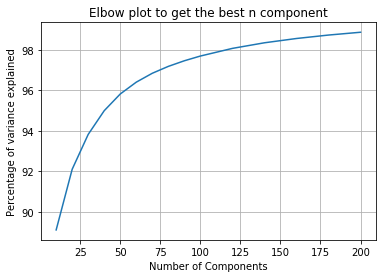

In [42]:
# Plotting the elbow plot to get the best value of n components.
plt.plot(n_comp,n_var)
plt.xlabel("Number of Components")
plt.ylabel("Percentage of variance explained")
plt.title("Elbow plot to get the best n component")
plt.grid()
plt.show()

In [43]:
# We will take n_components=170
svd = TruncatedSVD(n_components=175,n_iter=10,random_state=42).fit(co_mat)
U = svd.transform(co_mat)
print(U.shape)

(10000, 175)


### [5.4] Applying k-means clustering

In [44]:
from sklearn.cluster import KMeans

k_cluster = [1,2,3,4,5,6,7,8,9]
inertia = []

for k in tqdm(k_cluster):
    kmean = KMeans(n_clusters=k,max_iter=50,n_jobs=-1)
    kmean.fit(U)
    inertia.append(kmean.inertia_)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.18s/it]


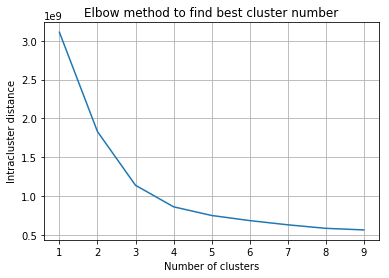

In [45]:
# Plotting elbow graph to select best cluster number
plt.plot(k_cluster,inertia)
plt.xlabel("Number of clusters")
plt.ylabel("Intracluster distance")
plt.title("Elbow method to find best cluster number")
plt.grid()
plt.show()

In [77]:
# Clustering with n_clusters = 2
kmean = KMeans(n_clusters=3,max_iter=50,n_jobs=-1)
kmean.fit(U)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [78]:
labels=kmean.labels_

In [83]:
len(labels)

10000

In [84]:
cluster0 = [] 
cluster1 = []
cluster3 = []

terms = tfidf_vectorizer.get_feature_names()




for i in range(len(labels)):
    if(labels[i]==0):
        cluster0.append(terms[i])
    elif(labels[i]==1):
        cluster1.append(terms[i])
    else:
        cluster3.append(terms[i])
    

In [85]:
print("Length of cluster {} is {}".format(0,len(cluster0)))
print("Length of cluster {} is {}".format(1,len(cluster1)))
print("Length of cluster {} is {}".format(2,len(cluster3)))

Length of cluster 0 is 9951
Length of cluster 1 is 2
Length of cluster 2 is 47


### [5.5] Wordclouds of clusters obtained in the above section

In [63]:
from wordcloud import WordCloud
def plot_wordcloud(reviews):
    wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                min_font_size = 10).generate(str(reviews)) 
  
    return wordcloud

[[  1   2  13  12  36  28  16  10   7  17  61  40  49  76  69  30 103  20
   56  58  44  52  23  88  65  78  95  62  97 137  14  86  63  24  22 135
  131 133 111 108 152  21  80 134 172  46 173  33 109  91 169 117  90  98
   70 154  47 142  75 126   5 130 124 174 132  81  66  43 140 107  89 151
  123 118  35 156 138 149  77 170 104 100 158 162 120 145  99  79 127  87
  153 171 101 113 115 160 168  39  26  60 163 141 102  68 125 147 143 128
  110 164 166   4  31 121 150 148 146 136 105  74 155  38  53  73  48  72
   67 112 157 122  50  25 159  64  57  84 106 165 161  92 114 129 144  15
   29  96  82 139  45 167 116  93  85  37  55  94  83  42 119  32  51  18
    9  19  34  54  27  71  59  11  41   3   8   6   0]
 [  2   7   5  11   6   9  18  15  19  10  26  24  41  20  27  54  29  50
   45  42  71  31  25  37  52  43  64  59  21  39  47  32  96  90  51  82
   93  49 102 139  74  85  92  70  60 116  79 122 157  67 119  83  73 167
  121  98  33  34 136 114  63  48 152 131 118  99 146 106

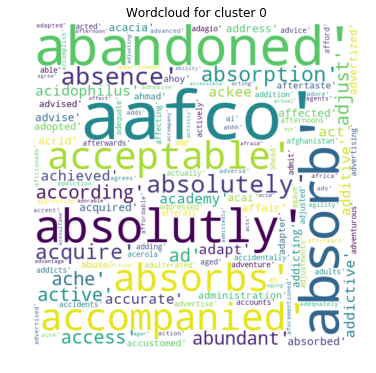

Cluster 1
['abandoned', 'absence', 'able', 'absolutley', 'abroad', 'absolute', 'absurd', 'absorbing', 'abundance', 'absolutely', 'accent', 'acai', 'accordingly', 'abundant', 'accept', 'acidic', 'accepted', 'aches', 'accurately', 'account', 'activities', 'accessible', 'acana', 'accompaniment', 'achieved', 'accounts', 'across', 'acknowledge', 'abuse', 'accomplish', 'acerola', 'accident', 'additives', 'adding', 'achieve', 'added', 'additionally', 'ache', 'adhesive', 'affects', 'actual', 'addicted', 'additional', 'actively', 'acne', 'adult', 'adapted', 'advantages', 'age', 'acting', 'advance', 'addendum', 'acts', 'agreed', 'advantage', 'addressed', 'accidentally', 'accidently', 'affect', 'adores', 'acrid', 'acesulfame', 'aftertaste', 'advertized', 'adults', 'adds', 'afraid', 'adjustment', 'ahead', 'addict', 'ages', 'africa', 'agility', 'ads', 'admittedly', 'additive', 'aficionados', 'ah', 'ago', 'advanced', 'agrees', 'adjustments', 'ahhh', 'acidity', 'afterwards', 'affair', 'african', 'agi

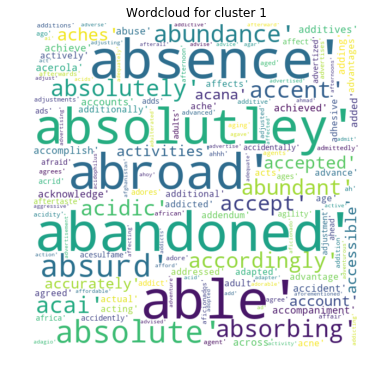

In [91]:
from wordcloud import WordCloud, STOPWORDS

stopwords_t = set(STOPWORDS)

centroids = kmean.cluster_centers_.argsort()
print(centroids)

terms = tfidf_vectorizer.get_feature_names()

reviews = []

for i in range(2):
    print("Cluster {}".format(i))
    for j in centroids[i, :200]: # This takes top 50 words of each cluster. 
        reviews.append(terms[j])
        
    print(reviews)
    wc = plot_wordcloud(reviews)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title("Wordcloud for cluster {}".format(i))
    plt.show()
    reviews.clear()

### [5.6] Function that returns most similar words for a given word.

In [68]:
# Standarizing the co_occurance matrix
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False).fit(co_mat)
co_mat = std.transform(co_mat)

In [71]:
# Function that will return 10 most similar words
def similar_words(word,n):
    # Getting word vector
    row = vocab.get(word,-1) # Finds word in the vocababulary.
    if(row == -1):
        print("Word is not present in the vocabulary")
        return
    else:
        wrd_vect = co_mat[row] # This will give vector of 175 dimension for the word
        # Now we will use np.linalg.norm function to find similarity of this vector with all the datapoints
        nearest_point = np.linalg.norm(co_mat-wrd_vect,axis=1)
        #similarity.pop(row) # Removing similarity with self as this will always be the highest.
        
        # Now we will sort these similarity
        # We start from 1 as 0th point is the point itself.
        sorted_nearest = np.argsort(nearest_point)[1:n+1] # Takes index of 10 most similar words i.e. nearest 10 point.
        
        # We will get all the values of keys . They are row numbers and if we have row number we can get word corresponding 
        # to that row number.
        row_value = [] # Contains row number of all 10k words.
        words = [] # Contains all 10k words.
        for key ,value in vocab.items():
            row_value.append(value)
            words.append(key)
            
        # checking the index of top 10 similar words and storing the word in a list.
        similar_words = []
        for row in sorted_nearest:
            if(row in row_value): # If similar word in dict.
                similar_words.append(words[row])
        print("{} most similar words of given word ({}) are::".format(n,word))  
        return similar_words    # Returning similar words and similarity.

In [74]:
similar_words('love',15)# Pass the value for the number of similar words you want

15 most similar words of given word (love) are::


['favorite',
 'delicious',
 'loved',
 'think',
 'wonderful',
 'enjoy',
 'tasty',
 'perfect',
 'lot',
 'always',
 'tastes',
 'since',
 'stuff',
 'however',
 'nice']

# [6] Conclusions

<h4>In this we have used 100k datapoints and used tfidf vectorizer. We selected top 10k features for this assignment.</h4>
<h4>After this we created a dictionary with feature as key and index as value. This index is then used as row in the co-occurance matrix.</h4>
<h4>we declared an array of size 10000x10000 . Then we iterated through each document in the corpus and took a window size of 3 in both the direaction of a word to find co-occurance value for a word.</h4>
<h4>Care havs been taken for corner cases . For words in start and the end of review we have kept conditional statements . This can be understood easily from the code segment written in above sections.</h4>
<h4>After this we get co-occurance matrix which contains the occurance of a other words in  context of given words.</h4>
<h4>On this matrix we have use TruncatedSVD to reduce the dimensions . To select best value of components we have used elbow method . In this we plotted value of variance retained for various value of components and selected n_components = 175</h4>
<h4>Then we have used k-means clustering on top of this and we selected best number of clusters using elbow method. We have trained k-means on various value of clusters and plotted value of inertia. We selected best value of n_clusters = 2.</h4>
<h4>Then we plotted top 50 words from each of the 2 clusters.</h4>
<h4>To print most similar words of a given words we did the following.</h4>
<h4>We have standarized the co-occurance matrix so that we get actual similarity between two words as some cells may have very large values and some may have very low values . This give a false picture of the similarity between points.</h4>
<h4>First get the row number of the word using the vocab dictionary that contains words as key and row number as value.</h3>
<h4>Using row number we got the vector representation of the given word.</h4>
<h4>Now we calculated similarity of this vectors with all the vecctors of co-occurance matrix. Then we sorted this value in ascending order. And took the first 10 indices.  We start from 1th index as 0th index will be the same point as a point is most similar to itself. Therefore we take indices from 1 ti n+1 where n is the number of similar points we want.</h4>
<h4>Using these 10 indices we got the words from the vocab dictionary and returned top 10 most similar words of the given word.</h4>